In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as spi
from IPython.display import Image
from matplotlib import rcParams
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 26
rcParams['legend.fontsize']= 'x-large'
rcParams['axes.titlesize']= 'x-large'
rcParams['xtick.labelsize']= 'x-large'
rcParams['ytick.labelsize']= 'x-large'
rcParams['axes.labelsize']= 'x-large'
rcParams['figure.titlesize']= 'xx-large'
rcParams['legend.title_fontsize']= 'xx-large'
%matplotlib inline
#rcParams.keys()

# Problema de Introducción.

Veamos un pequeño problema de modelamiento matemático como motivación a estudiar lo siguiente.

Este gráfico ilustra la evolución de la temperatura global en superficie con respecto a las temperaturas medias de 1951-1980. Diecinueve de los años más calurosos se han producido desde 2000, con la excepción de 1998. El año 2020 empató con 2016 como el año más caluroso registrado desde que se empezaron a llevar registros en 1880 (fuente: NASA/GISS). Esta investigación coincide en líneas generales con construcciones similares elaboradas por la Unidad de Investigación Climática y la Administración Nacional Oceánica y Atmosférica. La serie temporal que aparece a continuación muestra la variación media de cinco años de las temperaturas superficiales globales. El azul oscuro indica las zonas más frías que la media. El rojo oscuro indica las zonas más cálidas que la media.

La cifra de "Temperatura Global" en el tablero de la página principal muestra el cambio de la temperatura global desde 1880. Se obtiene esta cifra restando el primer punto de datos del gráfico del último punto de datos.

<img width="99%" src="../figures/global_temp_nasa_noaa.png"/> 

In [2]:
temp_data=pd.read_csv("../datas/global_temp_nasa_noaa.txt",delimiter="\s+",skiprows=2,header=0)
temp_data.head()

,Year,No_Smoothing,Lowess(5)
0,1880,-0.16,-0.09
1,1881,-0.08,-0.12
2,1882,-0.10,-0.16
3,1883,-0.17,-0.20
4,1884,-0.28,-0.23


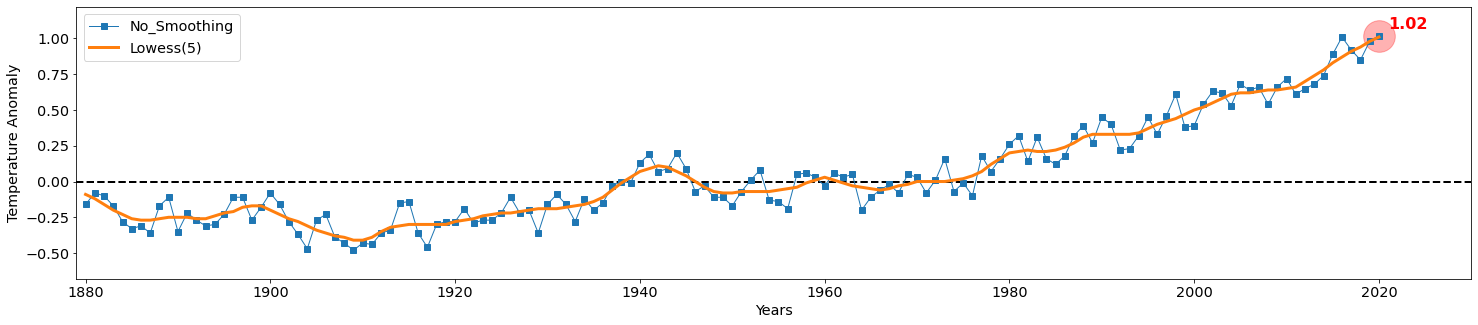

In [3]:
plt.figure(figsize=(25,5))
plt.plot(temp_data["Year"],temp_data["No_Smoothing"],marker="s",linewidth=1,label="No_Smoothing")
plt.plot(temp_data["Year"],temp_data["Lowess(5)"],linewidth=3,label="Lowess(5)")
plt.xlabel("Years")
plt.ylabel("Temperature Anomaly")
plt.text(temp_data["Year"].iloc[-1]+1,temp_data["No_Smoothing"].iloc[-1]+0.05,str(temp_data["No_Smoothing"].iloc[-1]),fontsize=16,color="red",weight="bold")
plt.axis([temp_data["Year"].min()-1,temp_data["Year"].max()+10,temp_data["No_Smoothing"].min()-0.2,temp_data["No_Smoothing"].max()+0.2])
plt.scatter(temp_data["Year"].iloc[-1],temp_data["No_Smoothing"].iloc[-1],s=1000,alpha=0.3,color="red")
plt.hlines(0,temp_data["Year"].min()-1,temp_data["Year"].max()+10,linestyles='--',color="k")
plt.legend()
plt.show()

### ¿Cómo podemos ver cuál será la razón de cambio de la anomalía de temperatura global de tal manera que podamos observar cuanto es la variación por año?

Esa es la pregunta que queremos responder y queremos resolver usando en este caso modelado en Python.

# Diferenciación Numérica en Python

## Enunciado del problema de diferenciación numérica

Una malla numérica es un conjunto de puntos espaciados uniformemente sobre el dominio de una función (es decir, la variable independiente), en algún intervalo. El espaciamiento o tamaño de paso de una cuadrícula numérica es la distancia entre puntos adyacentes en la cuadrícula. Si $x$ es una malla numérica, $x_j$ es el punto $j$ de la malla numérica y $h$ es el espaciado entre $x_{j-1}$ y $x_j$. La siguiente figura muestra un ejemplo de cuadrícula numérica.

<img width="40%" src="../figures/Numerical_grid.png">

Existen varias funciones en Python que pueden utilizarse para generar mallas numéricas. Para las rejillas numéricas en una dimensión, basta con utilizar la función linspace, que ya ha utilizado para crear matrices regularmente espaciadas.

En Python, una función $f(x)$ puede representarse en un intervalo calculando su valor en una cuadrícula. Aunque la función en sí puede ser continua, esta representación discreta o discretizada es útil para los cálculos numéricos y se corresponde con los conjuntos de datos que pueden adquirirse en la práctica de la ingeniería y la ciencia. En concreto, el valor de la función puede conocerse sólo en puntos discretos. Por ejemplo, un sensor de temperatura puede entregar pares de temperatura versus tiempo en intervalos de tiempo regulares. Aunque la temperatura es una función suave y continua del tiempo, el sensor sólo proporciona valores en intervalos de tiempo discretos, y en este caso particular, la función subyacente ni siquiera se conocería.

Tanto si $f$ es una función analítica o una representación discreta de una, nos gustaría derivar métodos de aproximación de la derivada de $f$ sobre una malla numérica y determinar su precisión.


## Derivadas de aproximación por diferencia finita

La derivada $f'(x)$ de una función $f(x)$ en el punto $x=a$ se define como:

\begin{equation}
f'(a)=\lim_{x\rightarrow a}\frac{f(x)-f(a)}{x-a}$
\end{equation}

La derivada en $x=a$ es la pendiente en este punto. En las aproximaciones por diferencias finitas de esta pendiente, podemos utilizar valores de la función en la vecindad del punto $x=a$ para lograr el objetivo. Hay varias fórmulas de diferencias finitas utilizadas en diferentes aplicaciones, y a continuación se presentan tres de ellas, en las que la derivada se calcula utilizando los valores de dos puntos. 

La diferencia directa (o hacia delante) consiste en estimar la pendiente de la función en $x_j$ utilizando la línea que une $(x_j,f(x_j))$ y $(x_{j+1},f(x_{j+1}))$:

\begin{equation}
f'(x_j)=\frac{f(x_{j+1})-f(x_j)}{x_{j+1}-x_j}+\mathcal{O}(x_{j+1}-x_j)=\frac{f(x_{j+1})-f(x_j)}{h}++\mathcal{O}(h)$, \ \ \mbox{con}\ \  h=x_{j+1}-x_j.
\end{equation}

La diferencia hacia atrás consiste en estimar la pendiente de la función en $x_j$ utilizando la línea que une $(x_{j-1},f(x_{j-1}))$ y $(x_j,f(x_j))$:

\begin{equation}
f'(x_j)=\frac{f(x_j)-f(x_{j-1})}{x_j-x_{j-1}}+\mathcal{O}(x_j-x_{j-1})=\frac{f(x_j)-f(x_{j-1})}{h}+\mathcal{O}(h), \ \ \mbox{con $h$ también igual a}\ \  h=x_j-x_{j-1}.
\end{equation}

La diferencia central consiste en estimar la pendiente de la función en $x_j$ utilizando la línea que une $(x_{j-1},f(x_{j-1}))$ y $(x_{j+1},f(x_{j+1}))$:

\begin{equation}
f'(x_j)=\frac{f(x_{j+1})-f(x_{j-1})}{x_{j+1}-x_{j-1}}+\mathcal{O}(x_j-x_{j-1})=\frac{f(x_{j+1})-f(x_{j-1})}{2h}+\mathcal{O}(h), \ \ \mbox{con}\ \ 2h=x_{j+1}-x_{j-1}.
\end{equation}

La siguiente figura ilustra los tres tipos de fórmulas para estimar la pendiente.

<img width="80%" src="../figures/Finite-difference.png">

Esta fórmula es una mejor aproximación para la derivada en $x_j$ que la fórmula de la diferencia central, pero requiere el doble de cálculos.

\begin{equation}
f'(x_j)=\frac{f(x_{j-2})-8f(x_{j-1})+8f(x_{j+1})-f(x_{j+2})}{12h}+\mathcal{O}(h^4).
\end{equation}


**¡CONSEJO!** Python tiene un comando que puede utilizarse para calcular directamente las diferencias finitas: para un vector $f$, el comando `d=np.diff(f)`  produce una matriz $d$ en la que las entradas son las diferencias de los elementos adyacentes en la matriz inicial $f$. En otras palabras, $d(i)=f(i+1)-f(i)$.

**¡ATENCIÓN!** Cuando se utiliza el comando `np.diff`, el tamaño de la salida es uno menos que el tamaño de la entrada ya que necesita dos argumentos para producir una diferencia.

**EJEMPLO:** Consideremos la función $f(x)=cos(x)$. Sabemos que la derivada de $cos(x)$ es $-sin(x)$. Aunque en la práctica puede que no conozcamos la función subyacente para la que estamos encontrando la derivada, utilizamos el ejemplo simple para ilustrar los métodos de diferenciación numérica mencionados y su precisión. El siguiente código calcula las derivadas numéricamente.

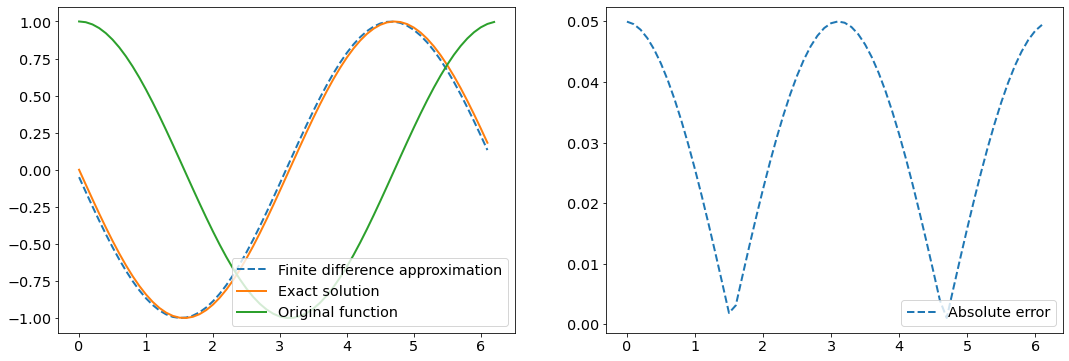

Error máximo es = 0.049984407218554114


In [4]:
# step size
h = 0.1
# define grid
x = np.arange(0, 2*np.pi, h) 
# compute function
y = np.cos(x) 

# compute vector of forward differences
forward_diff = np.diff(y)/h 
# compute corresponding grid
x_diff = x[:-1:] 
# compute exact solution
exact_solution = -np.sin(x_diff) 

# Plot solution
plt.figure(figsize = (18, 6))
plt.subplot(121)
plt.plot(x_diff,forward_diff,'--',label='Finite difference approximation')
plt.plot(x_diff,exact_solution,label='Exact solution')
plt.plot(x,y,label='Original function')
plt.legend(loc=4)
plt.subplot(122)
plt.plot(x_diff, abs(forward_diff-exact_solution),'--',label='Absolute error')

plt.legend(loc=4)
plt.show()

# Compute max error between 
# numerical derivative and exact solution
max_error = max(abs(exact_solution - forward_diff))
print("Error máximo es =",max_error)

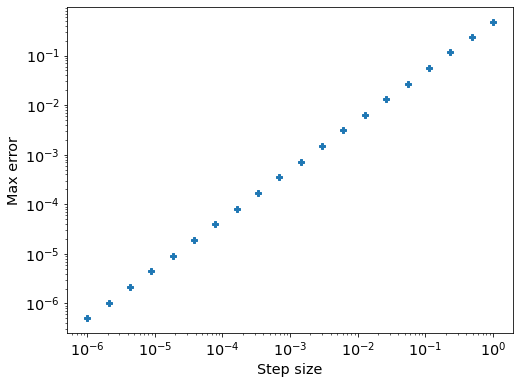

In [5]:
# En el ejemplo anterior hemos hecho pasos de tamaño h=0.1. Vamos a ver como serían los errores considerando diferentes tamaños de paso o sub intervalos.
# define step size
h=np.logspace(0,-6,20)
# list to store max error for each step size
max_error = [] 

for i in h:
    x = np.arange(0, 2 * np.pi, i) 
    # compute function value at grid
    y = np.cos(x) 
    # compute vector of forward differences
    forward_diff = np.diff(y)/i 
    # compute corresponding grid
    x_diff = x[:-1] 
    # compute exact solution
    exact_solution = -np.sin(x_diff) 
    
    # Compute max error between numerical derivative and exact solution
    max_error.append(max(abs(exact_solution - forward_diff)))

# produce log-log plot of max error versus step size
plt.figure(figsize = (8, 6))
plt.loglog(h, max_error,marker='P',linewidth=0)
plt.xlabel("Step size")
plt.ylabel("Max error")
plt.show()

## Varias maneras de hacerlo

### Implementación usando definición

In [6]:
def derivative_0(f,a,method='central',h=0.01):
    '''Compute the difference formula for f'(a) with step size h.

    Parameters
    ----------
    f : function
        Vectorized function of one variable
    a : number
        Compute derivative at x = a
    method : string
        Difference formula: 'forward', 'backward' or 'central'
    h : number
        Step size in difference formula

    Returns
    -------
    float
        Difference formula:
            central: f(a+h) - f(a-h))/2h
            forward: f(a+h) - f(a))/h
            backward: f(a) - f(a-h))/h            
    '''
    if method == 'central':
        return (f(a + h) - f(a - h))/(2*h)
    elif method == 'forward':
        return (f(a + h) - f(a))/h
    elif method == 'backward':
        return (f(a) - f(a - h))/h
    else:
        raise ValueError("Method must be 'central', 'forward' or 'backward'.")

In [7]:
x1=np.linspace(-5,5,100)
f1=lambda x: x**4-4*x**3-x**2+10*x

In [8]:
derivative_0(f1,2)

-9.999599999999731

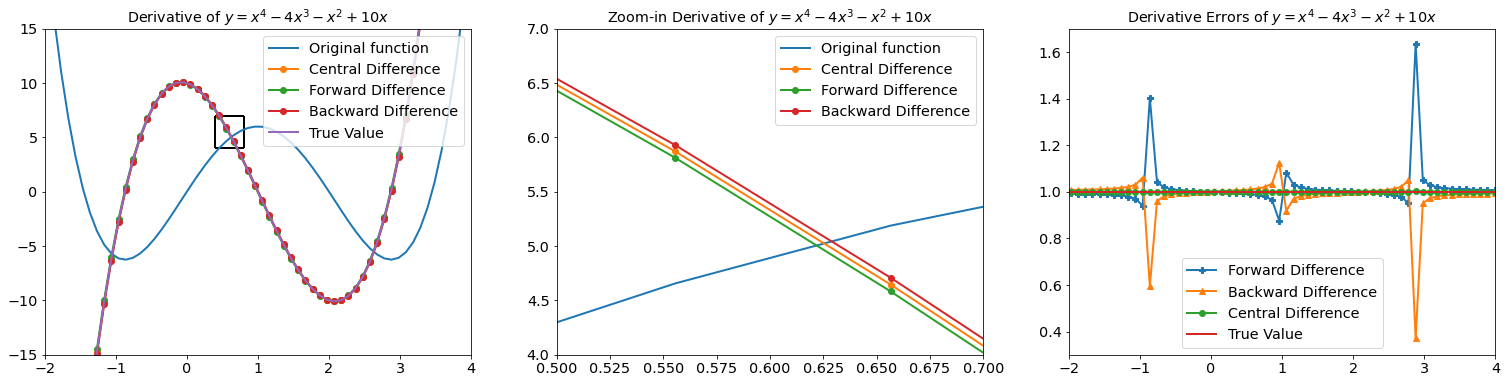

In [9]:
dydx = derivative_0(f1,x1)
dydx_b = derivative_0(f1,x1,method='backward')
dydx_f = derivative_0(f1,x1,method='forward')

dYdx = 4*x1**3-12*x1**2-2*x1+10

plt.figure(figsize=(26,6))
plt.subplot(131)
plt.plot(x1,f1(x1),label="Original function")
plt.plot(x1,dydx,'o-',label='Central Difference')
plt.plot(x1,dydx_f,'o-',label='Forward Difference')
plt.plot(x1,dydx_b,'o-',label='Backward Difference')
plt.plot(x1,dYdx,label='True Value')
plt.title('Derivative of $y = x^4-4x^3-x^2+10x$')
plt.legend(loc='best')
plt.hlines(4,0.4,0.8,linestyles='-',color='k')
plt.hlines(7,0.4,0.8,linestyles='-',color='k')
plt.vlines(0.4,4,7,linestyles='-',color='k')
plt.vlines(0.8,4,7,linestyles='-',color='k')
plt.ylim(-15,15)
plt.xlim(-2,4)
plt.subplot(132)
plt.plot(x1,f1(x1),label="Original function")
plt.plot(x1,dydx,'o-',label='Central Difference')
plt.plot(x1,dydx_f,'o-',label='Forward Difference')
plt.plot(x1,dydx_b,'o-',label='Backward Difference')
#plt.plot(x1,dYdx,label='True Value')
plt.title('Zoom-in Derivative of $y = x^4-4x^3-x^2+10x$')
plt.legend(loc='best')
plt.ylim(4,7)
plt.xlim(0.5,0.7)
plt.subplot(133)
plt.plot(x1,dydx_f/dYdx,'P-',label='Forward Difference')
plt.plot(x1,dydx_b/dYdx,'^-',label='Backward Difference')
plt.plot(x1,dydx/dYdx,'o-',label='Central Difference')
plt.plot(x1,dYdx/dYdx,label='True Value')
plt.title('Derivative Errors of $y = x^4-4x^3-x^2+10x$')
plt.legend(loc='best')
plt.ylim(0.3,1.7)
plt.xlim(-2,4)
plt.show()

Calculemos y tracemos la derivada de una función complicada

\begin{equation}
f(x)=\left(\frac{4x^2+2x+1}{x+2e^x}\right)^x
\end{equation}

<img width="80%" src="../figures/Screenshot2021-09-23.png">

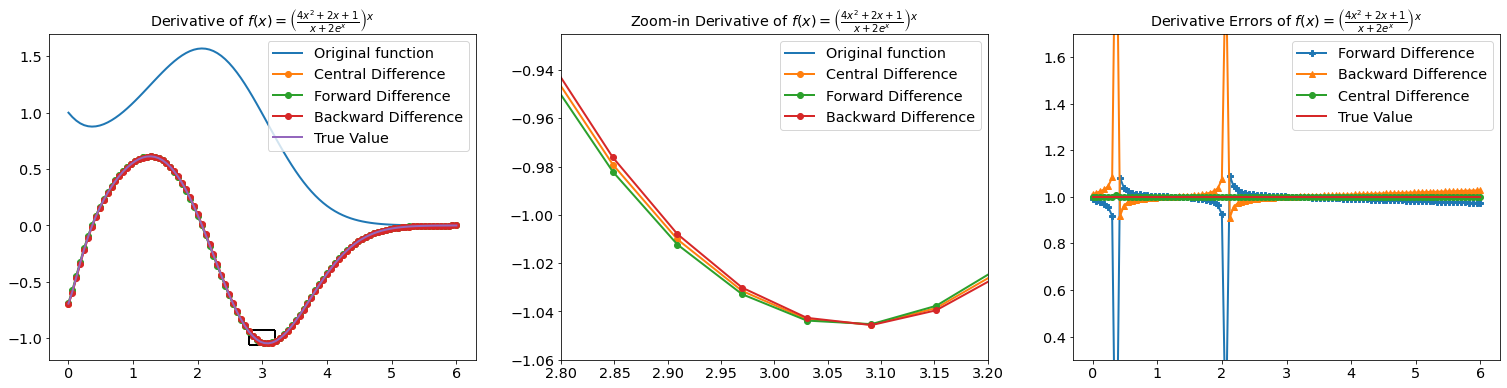

In [10]:
x2 = np.linspace(0,6,100)
f2 = lambda x: ((4*x**2 + 2*x + 1)/(x + 2*np.exp(x)))**x
y2 = f2(x2)
dydx2 = derivative_0(f2,x2)
dydx_b2 = derivative_0(f2,x2,method='backward')
dydx_f2 = derivative_0(f2,x2,method='forward')
dYdx2 = ((4*x2**2+2*x2+1)/(x2+2*np.exp(x2)))**x2*(np.log((4*x2**2+2*x2+1)/(x2+2*np.exp(x2)))+x2*((8*x2+2)/(x2+2*np.exp(x2))-(4*x2**2+2*x2+1)*(1+2*np.exp(x2))/(x2+2*np.exp(x2))**2)*(x2+2*np.exp(x2))/(4*x2**2+2*x2+1))
plt.figure(figsize=(26,6))
plt.subplot(131)
plt.plot(x2,f2(x2),label="Original function")
plt.plot(x2,dydx2,'o-',label='Central Difference')
plt.plot(x2,dydx_f2,'o-',label='Forward Difference')
plt.plot(x2,dydx_b2,'o-',label='Backward Difference')
plt.plot(x2,dYdx2,label='True Value')
plt.title(r'Derivative of $f(x)=\left(\frac{4x^2+2x+1}{x+2e^x}\right)^x$')
plt.legend(loc='best')
plt.hlines(-1.06,2.8,3.2,linestyles='-',color='k')
plt.hlines(-0.925,2.8,3.2,linestyles='-',color='k')
plt.vlines(2.8,-1.06,-0.925,linestyles='-',color='k')
plt.vlines(3.2,-1.06,-0.925,linestyles='-',color='k')
#plt.ylim(-15,15)
#plt.xlim(-2,4)
plt.subplot(132)
plt.plot(x2,f2(x2),label="Original function")
plt.plot(x2,dydx2,'o-',label='Central Difference')
plt.plot(x2,dydx_f2,'o-',label='Forward Difference')
plt.plot(x2,dydx_b2,'o-',label='Backward Difference')
#plt.plot(x1,dYdx,label='True Value')
plt.title(r'Zoom-in Derivative of $f(x)=\left(\frac{4x^2+2x+1}{x+2e^x}\right)^x$')
plt.legend(loc='best')
plt.ylim(-1.06,-0.925)
plt.xlim(2.8,3.2)
plt.subplot(133)
plt.plot(x2,dydx_f2/dYdx2,'P-',label='Forward Difference')
plt.plot(x2,dydx_b2/dYdx2,'^-',label='Backward Difference')
plt.plot(x2,dydx2/dYdx2,'o-',label='Central Difference')
plt.plot(x2,dYdx2/dYdx2,label='True Value')
plt.title(r'Derivative Errors of $f(x)=\left(\frac{4x^2+2x+1}{x+2e^x}\right)^x$')
plt.legend(loc='best')
plt.ylim(0.3,1.7)
#plt.xlim(-2,4)
plt.show()

### Otras opciones

`scipy.misc.derivative`: La función de SciPy `scipy.misc.derivative` calcula las derivadas utilizando la fórmula de la diferencia central.

In [11]:
from scipy.misc import derivative

x = np.arange(0,5)
derivative(np.exp,x,dx=0.1)

array([ 1.0016675 ,  2.72281456,  7.40137735, 20.11902956, 54.68919246])

De esta manera entonces además es muy sencillo definir y calcular las derivadas de orden superior. ¿Qué pasa con la segunda, tercera, etc., derivadas? Pues muy sencillo con la función `scipy.misc.derivative` es muy fácil hallarlas. De hecho, si miramos la documentación de `scipy.misc.derivative` veremos que hay un argumento:

Find the nth derivative of a function at a point.

Given a function, use a central difference formula with spacing `dx` to
compute the nth derivative at `x0`.

| | Parameters | |
| --- | --- | ---|
| func | function | Input function |
| x0 | float | The point at which the nth derivative is found. | 
| dx | float, optional | Spacing. | 
| n | int, optional | Order of the derivative. Default is 1. | 
| order | int, optional | Number of points to use, must be odd. | 

Por ejemplo:

In [12]:
x = np.arange(0,50)
derivative(lambda x: x*np.exp(x),x,dx=0.1,order = 31,n=1)

array([1.00000000e+00, 5.43656366e+00, 2.21671683e+01, 8.03421477e+01,
       2.72990750e+02, 8.90478955e+02, 2.82400155e+03, 8.77306527e+03,
       2.68286219e+04, 8.10308393e+04, 2.42291124e+05, 7.18489701e+05,
       2.11581229e+06, 6.19378749e+06, 1.80390643e+07, 5.23042780e+07,
       1.51063879e+08, 4.34789150e+08, 1.24753941e+09, 3.56964602e+09,
       1.01884691e+10, 2.90139462e+10, 8.24529955e+10, 2.33875283e+11,
       6.62228053e+11, 1.87212738e+12, 5.28469945e+12, 1.48973507e+13,
       4.19414549e+13, 1.17940029e+14, 3.31280712e+14, 9.29563189e+14,
       2.60577769e+15, 7.29788171e+15, 2.04211610e+16, 5.70964843e+16,
       1.59515567e+17, 4.45327410e+17, 1.24238134e+18, 3.46373602e+18,
       9.65079594e+18, 2.68734267e+19, 7.47888225e+19, 2.08024937e+20,
       5.78322005e+20, 1.60697647e+21, 4.46317613e+21, 1.23903019e+22,
       3.43820060e+22, 9.53673286e+22])

In [13]:
derivative(lambda x: x*np.exp(x),x,dx=0.1,order = 31,n=2)

array([2.00000000e+00, 8.15484549e+00, 2.95562244e+01, 1.00427685e+02,
       3.27588900e+02, 1.03889211e+03, 3.22743035e+03, 9.86969843e+03,
       2.98095799e+04, 8.91339232e+04, 2.64317590e+05, 7.78363842e+05,
       2.27856708e+06, 6.63620088e+06, 1.92416685e+07, 5.55732953e+07,
       1.59949989e+08, 4.58944102e+08, 1.31319938e+09, 3.74812832e+09,
       1.06736343e+10, 3.03327619e+10, 8.60379083e+10, 2.43620086e+11,
       6.88717175e+11, 1.94413228e+12, 5.48042906e+12, 1.54293990e+13,
       4.33877119e+13, 1.21871363e+14, 3.41967187e+14, 9.58612039e+14,
       2.68474065e+15, 7.51252529e+15, 2.10046227e+16, 5.86824977e+16,
       1.63826799e+17, 4.57046553e+17, 1.27423727e+18, 3.55032942e+18,
       9.88618121e+18, 2.75132702e+19, 7.65280974e+19, 2.12752776e+20,
       5.91173605e+20, 1.64191074e+21, 4.55813732e+21, 1.26484331e+22,
       3.50836796e+22, 9.72746752e+22])

In [14]:
derivative(lambda x: x*np.exp(x),x,dx=0.1,order = 31,n=3)

array([3.00000000e+00, 1.08731273e+01, 3.69452805e+01, 1.20513222e+02,
       3.82187050e+02, 1.18730527e+03, 3.63085914e+03, 1.09663316e+04,
       3.27905379e+04, 9.72370071e+04, 2.86344055e+05, 8.38237984e+05,
       2.44132187e+06, 7.07861427e+06, 2.04442728e+07, 5.88423127e+07,
       1.68836100e+08, 4.83099055e+08, 1.37885935e+09, 3.92661062e+09,
       1.11587995e+10, 3.16515776e+10, 8.96228212e+10, 2.53364890e+11,
       7.15206297e+11, 2.01613718e+12, 5.67615867e+12, 1.59614472e+13,
       4.48339690e+13, 1.25802698e+14, 3.52653661e+14, 9.87660889e+14,
       2.76370361e+15, 7.72716887e+15, 2.15880845e+16, 6.02685112e+16,
       1.68138030e+17, 4.68765695e+17, 1.30609320e+18, 3.63692282e+18,
       1.01215665e+19, 2.81531137e+19, 7.82673724e+19, 2.17480616e+20,
       6.04025205e+20, 1.67684501e+21, 4.65309852e+21, 1.29065644e+22,
       3.57853532e+22, 9.91820218e+22])

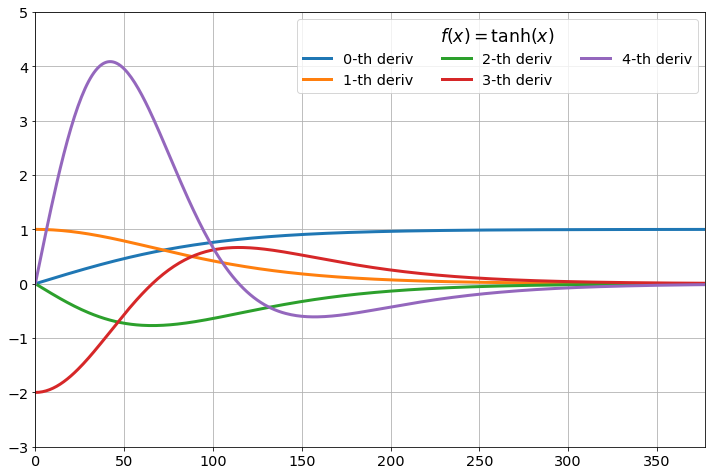

In [15]:
plt.figure(figsize=(12,8))
for i in range(5):
    x=np.arange(0,2*np.pi,0.01)
    plt.plot(derivative(lambda x: np.tanh(x),x,dx=0.1,order = 51,n=i),linewidth=3,label=r"{}-th deriv".format(i))
    plt.legend(title=r"$f(x)=\tanh(x)$",ncol=3)
    plt.axis([0,120*np.pi,-3,5])
plt.grid()
plt.show()